# Discrete hedging experiment for a European Call option under the Heston model

> TODO: Add a description to the experiment

> Under the Heston but we are using the Black-Scholes delta for hedging

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd

from jax import vmap
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','no-latex'])

from jaxfin.models.heston import UnivHestonModel
from jaxfin.price_engine.black_scholes import european_price, delta_european
from jaxfin.price_engine.fft import fourier_inv_call, delta_call_fourier

from src.heston.fourier import fourier_inv_call_1, delta_call
from src.experimental.bs_iv import IV_brent

In [3]:
seed = 42

$$
S(0) = 100 \\
\sigma = 0.2 \\
\mu = 0.00 \\
$$

Let set $N = 252$, which means that we are rebalancing our portfolio daily.

In [4]:
# Initialize the Univariate Heston Model
s0 = 100.0
v0 = 0.04
mean = 0.0
kappa = 1.0
theta = 0.04
sigma = 0.1
rho = -0.7

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)

In [5]:
maturity = 1.0
N = 252
dt = maturity / N
n_sim = 1000

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

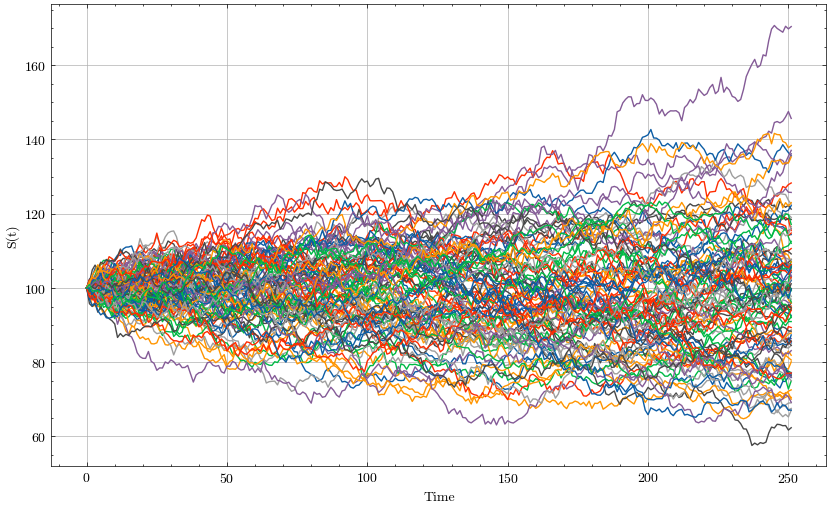

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(stock_paths[:, :100])
plt.ylabel('S(t)')
plt.xlabel('Time')
plt.grid()
plt.show()

In [7]:
discount_rate = 0.0
dividends = 0.0

## Hedging experiment without transaction costs

In [8]:
ticksize = 0.00
K = 100
maturity = 1.0
N = 252
n_sim = 100

v_fourier_delta_call = vmap(delta_call_fourier, in_axes=(0, None, None, None, None, None, None, None, None))
v_fourier_inv_call = vmap(fourier_inv_call, in_axes=(0, None, None, None, None, None, None, None, None))

In [9]:
def get_transaction_costs(ticksize, ddelta):
    return ticksize * (jnp.abs(ddelta) + 0.01 * ddelta**2)

In [10]:
def hedge_experiment_loop(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=0.00):
    deltas = [v_fourier_delta_call(stock_paths[i], K, maturity - i * dt, v0, mean, theta, sigma, kappa, rho) for i in range(0, N)]
    cs = [v_fourier_inv_call(stock_paths[i], K, maturity - i * dt, v0, mean, theta, sigma, kappa, rho) for i in range(0, N)]
    b = [cs[0] - deltas[0] * stock_paths[0]]
    vs = [cs[0] - get_transaction_costs(ticksize, deltas[0])]

    for i in range(1, N):
        ddelta = deltas[i] - deltas[i - 1] if i != N - 1 else deltas[i]
        vs.append(deltas[i - 1] * stock_paths[i] + b[i - 1] - get_transaction_costs(ticksize, ddelta))
        b.append(vs[i] - deltas[i] * stock_paths[i])
        
    hedge_error = jnp.asarray(vs) - jnp.maximum(stock_paths - K, 0)

    return jnp.mean(hedge_error[-1]), jnp.std(hedge_error[-1]) / jnp.asarray(cs)[0, 0]

### Experiments

In [11]:
results = {
    'Strike': [],
    'Sigma': [],
    'Maturity': [],
    'Rebalancing_freq': [],
    'E_PL_T': [],
    'Std_PL_T': []
}

In [12]:
def update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=0.00):
    mean_hedge_error, std_hedge_error = hedge_experiment_loop(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

    results['Strike'].append(K)
    results['Sigma'].append(sigma)
    results['Maturity'].append(maturity)
    results['Rebalancing_freq'].append(N)
    results['E_PL_T'].append(mean_hedge_error)
    results['Std_PL_T'].append(std_hedge_error)

    print(f'The mean hedge error is: {mean_hedge_error}')
    print(f'The normalized std of the hedge error is: {std_hedge_error}')

    return results

In [13]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.03405129536986351
The normalized std of the hedge error is: 0.11783048510551453


#### Different strike prices

$$
S_0 = 100 \quad K = 80 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [14]:
K = 80
sigma = 0.1
maturity = 1.0
N = 252
n_sim = 100

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [15]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.04793756082653999
The normalized std of the hedge error is: 0.03190455213189125


$$
S_0 = 100 \quad K = 90 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [16]:
K = 90

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [17]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.08411499112844467
The normalized std of the hedge error is: 0.05569570139050484


$$
S_0 = 100 \quad K = 110 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [18]:
K = 110

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [19]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.07436969876289368
The normalized std of the hedge error is: 0.24871216714382172


$$
S_0 = 100 \quad K = 120 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [20]:
K = 120

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [21]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.09306322038173676
The normalized std of the hedge error is: 0.46239426732063293


#### Different maturities with daily rebalancing

$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 0.75 \quad n = 252
$$

In [22]:
K = 100
T = 0.75
N = 252

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [23]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 1.25 \quad n = 252
$$

In [24]:
T = 1.25

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [25]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.9024631977081299
The normalized std of the hedge error is: 0.1606963723897934


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 2.00 \quad n = 252
$$

In [26]:
T = 2.0

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [27]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 2.999037742614746
The normalized std of the hedge error is: 0.23288588225841522


#### Different volatilities

$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.1 \quad T = 1.0 \quad n = 252
$$

In [28]:
K = 100
T = 1.0
N = 252
sigma = 0.2

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [29]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: -0.41691386699676514
The normalized std of the hedge error is: 0.24100923538208008


### Different Rebalancing periods

$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 52
$$

In [30]:
K = 100
sigma = 0.1
N = 52
T = 1.0

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [31]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: -0.09070956707000732
The normalized std of the hedge error is: 0.27451884746551514


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 121
$$

In [32]:
N = 121
T = 1.0

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [33]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.1808042824268341
The normalized std of the hedge error is: 0.2381397783756256


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 504
$$

In [34]:
N = 504
T = 1.0

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [35]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


In [36]:
res_df = pd.DataFrame.from_dict(results)
res_df

,Strike,Sigma,Maturity,Rebalancing_freq,E_PL_T,Std_PL_T
0,100,0.1,1.00,252,-0.034051295,0.117830485
1,80,0.1,1.00,252,-0.04793756,0.031904552
2,90,0.1,1.00,252,-0.08411499,0.0556957
3,110,0.1,1.00,252,0.0743697,0.24871217
4,120,0.1,1.00,252,0.09306322,0.46239427
5,100,0.1,0.75,252,nan,nan
6,100,0.1,1.25,252,0.9024632,0.16069637
7,100,0.1,2.00,252,2.9990377,0.23288588
8,100,0.2,1.00,252,-0.41691387,0.24100924
9,100,0.1,1.00,52,-0.09070957,0.27451885


In [37]:
res_df.to_csv('./results/heston_delta_zero.csv')

### Hedging experiments with low transcation costs

### Experiments

In [38]:
ticksize = 0.01
K = 100
sigma = 0.1
maturity = 1.0
N = 252
n_sim = 100

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [39]:
results = {
    'Strike': [],
    'Sigma': [],
    'Maturity': [],
    'Rebalancing_freq': [],
    'E_PL_T': [],
    'Std_PL_T': []
}

In [40]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.11727024614810944
The normalized std of the hedge error is: 0.11597351729869843


#### Different strike prices

$$
S_0 = 100 \quad K = 80 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [41]:
K = 80
sigma = 0.1
maturity = 1.0
N = 252
n_sim = 100

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [42]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.003267164109274745
The normalized std of the hedge error is: 0.0277055986225605


$$
S_0 = 100 \quad K = 90 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [43]:
K = 90

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [44]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.10246232151985168
The normalized std of the hedge error is: 0.06491737067699432


$$
S_0 = 100 \quad K = 110 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [45]:
K = 110

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [46]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.09741686284542084
The normalized std of the hedge error is: 0.24077750742435455


$$
S_0 = 100 \quad K = 120 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [47]:
K = 120

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [48]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.10791446268558502
The normalized std of the hedge error is: 0.4446091651916504


#### Different maturities with daily rebalancing

$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 0.75 \quad n = 252
$$

In [49]:
K = 100
T = 0.75
N = 252

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [50]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 1.25 \quad n = 252
$$

In [51]:
T = 1.25

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [52]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.9789314866065979
The normalized std of the hedge error is: 0.17430993914604187


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 2.00 \quad n = 252
$$

In [53]:
T = 2.0

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [54]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 3.4624595642089844
The normalized std of the hedge error is: 0.21864502131938934


#### Different volatilities

$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.1 \quad T = 1.0 \quad n = 252
$$

In [55]:
K = 100
T = 1.0
N = 252
sigma = 0.2

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [56]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: -0.07865282148122787
The normalized std of the hedge error is: 0.19711419939994812


### Different Rebalancing periods

$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 52
$$

In [57]:
K = 100
sigma = 0.1
N = 52
T = 1.0

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [58]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: -0.07421690970659256
The normalized std of the hedge error is: 0.2648134231567383


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 121
$$

In [59]:
N = 121
T = 1.0

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [60]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: -0.06395449489355087
The normalized std of the hedge error is: 0.21644526720046997


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 504
$$

In [61]:
N = 504
T = 1.0

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [62]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


In [63]:
res_df = pd.DataFrame.from_dict(results)
res_df

,Strike,Sigma,Maturity,Rebalancing_freq,E_PL_T,Std_PL_T
0,100,0.1,1.00,252,-0.117270246,0.11597352
1,80,0.1,1.00,252,-0.003267164,0.027705599
2,90,0.1,1.00,252,-0.10246232,0.06491737
3,110,0.1,1.00,252,-0.09741686,0.2407775
4,120,0.1,1.00,252,-0.10791446,0.44460917
5,100,0.1,0.75,252,nan,nan
6,100,0.1,1.25,252,0.9789315,0.17430994
7,100,0.1,2.00,252,3.4624596,0.21864502
8,100,0.2,1.00,252,-0.07865282,0.1971142
9,100,0.1,1.00,52,-0.07421691,0.26481342


In [64]:
res_df.to_csv('./results/c_delta_low.csv')

### Hedging experiments with high transcation costs

### Experiments

In [65]:
ticksize = 0.05
K = 100
sigma = 0.1
maturity = 1.0
N = 252
n_sim = 100

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [66]:
results = {
    'Strike': [],
    'Sigma': [],
    'Maturity': [],
    'Rebalancing_freq': [],
    'E_PL_T': [],
    'Std_PL_T': []
}

In [67]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.29731205105781555
The normalized std of the hedge error is: 0.12298296391963959


#### Different strike prices

$$
S_0 = 100 \quad K = 80 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [68]:
K = 80
sigma = 0.1
maturity = 1.0
N = 252
n_sim = 100

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [69]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.16849224269390106
The normalized std of the hedge error is: 0.028171777725219727


$$
S_0 = 100 \quad K = 90 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [70]:
K = 90

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [71]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.25331398844718933
The normalized std of the hedge error is: 0.059173598885536194


$$
S_0 = 100 \quad K = 110 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [72]:
K = 110

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [73]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.27348098158836365
The normalized std of the hedge error is: 0.21730637550354004


$$
S_0 = 100 \quad K = 120 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [74]:
K = 120

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [75]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.26975882053375244
The normalized std of the hedge error is: 0.37604817748069763


#### Different maturities with daily rebalancing

$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 0.75 \quad n = 252
$$

In [76]:
K = 100
T = 0.75
N = 252

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [77]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 1.25 \quad n = 252
$$

In [78]:
T = 1.25

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [79]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.785548985004425
The normalized std of the hedge error is: 0.1756182163953781


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 2.00 \quad n = 252
$$

In [80]:
T = 2.0

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [81]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 3.0921411514282227
The normalized std of the hedge error is: 0.2533990740776062


#### Different volatilities

$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.1 \quad T = 1.0 \quad n = 252
$$

In [82]:
K = 100
T = 1.0
N = 252
sigma = 0.2

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [83]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: -0.28551551699638367
The normalized std of the hedge error is: 0.2369787096977234


### Different Rebalancing periods

$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 52
$$

In [84]:
K = 100
sigma = 0.1
N = 52
T = 1.0

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [85]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.04767169803380966
The normalized std of the hedge error is: 0.2837994694709778


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 121
$$

In [86]:
N = 121
T = 1.0

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [87]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: -0.028650473803281784
The normalized std of the hedge error is: 0.22237470746040344


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 504
$$

In [88]:
N = 504
T = 1.0

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [89]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


In [90]:
res_df = pd.DataFrame.from_dict(results)
res_df

,Strike,Sigma,Maturity,Rebalancing_freq,E_PL_T,Std_PL_T
0,100,0.1,1.00,252,-0.29731205,0.122982964
1,80,0.1,1.00,252,-0.16849224,0.028171778
2,90,0.1,1.00,252,-0.253314,0.0591736
3,110,0.1,1.00,252,-0.27348098,0.21730638
4,120,0.1,1.00,252,-0.26975882,0.37604818
5,100,0.1,0.75,252,nan,nan
6,100,0.1,1.25,252,0.785549,0.17561822
7,100,0.1,2.00,252,3.0921412,0.25339907
8,100,0.2,1.00,252,-0.28551552,0.23697871
9,100,0.1,1.00,52,0.047671698,0.28379947


In [91]:
res_df.to_csv('./results/heston_delta_high.csv')